# Minimal Model Analysis

In [1]:
#Import libraries and modules

#from ipynb.fs.defs.data_processing import Yan_NN_data
#from ipynb.fs.defs.data_processing import Yan_data_Clean
#from ipynb.fs.defs.data_processing import keep_tot_stat
#from ipynb.fs.defs.data_processing import nan_to_zero

import time
import pandas as pd
import dill

import numpy as np
import math
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score

import tensorflow as tf
#import autokeras as ak

from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense

In [2]:
def Sort_Tuple(tup): 
    tup.sort(key = lambda x: x[1]) 
    return tup 

In [3]:
# Use the following only on the training data, not the validation one
# We will mostly use Standardize
# Should we normalize/standardize the Fantasy Points column? I think so...
def data_Normalize(data, target_col):
    newData=data.copy()
    
    for c in list(target_col):
        # First exception shouldn't happen since we deal with strings before
        if (not isinstance(data.loc[ data.index[0],c], str)) :
            minval=np.min(data[c])
            maxval=np.max(data[c])
            newData[c]=(data[c]-minval)/(maxval-minval)
            
    return newData

def data_Standardize(data, target_col):
    newData=data.copy()
    
    for c in list(data.columns):
        # First exception shouldn't happen since we deal with strings before
        if (not isinstance(data.loc[ data.index[0],c], str)) :
            avg=np.mean(data[c])
            std=np.std(data[c])
            newData[c]=(data[c]-avg)/std
            
    return newData

In [4]:
# Import data
dill_file = open("all_data_min_v1", "rb")
all_cleaned_data = dill.load(dill_file)
dill_file.close()

In [5]:
dill_file = open("all_col_names", "rb")
col_dict = dill.load(dill_file)
dill_file.close()
# Column dictionary for subset of column
min_col_names=[0,1,2,4,7,306,304,309,308,29,28,24,11]
min_col_dict={}
for i,j in enumerate(min_col_names):
    min_col_dict[i]=('S1',list(col_dict[j])[1])
for i,j in enumerate(min_col_names):
    min_col_dict[i+len(min_col_names)]=('S2',list(col_dict[j])[1])
min_col_dict

{0: ('S1', 'Name'),
 1: ('S1', 'Fantasy Points'),
 2: ('S1', 'Position'),
 3: ('S1', 'Age'),
 4: ('S1', 'GP'),
 5: ('S1', 'PTS'),
 6: ('S1', 'G'),
 7: ('S1', 'S'),
 8: ('S1', 'PIM'),
 9: ('S1', 'HIT'),
 10: ('S1', 'BLK'),
 11: ('S1', 'ATOI'),
 12: ('S1', '+/-'),
 13: ('S2', 'Name'),
 14: ('S2', 'Fantasy Points'),
 15: ('S2', 'Position'),
 16: ('S2', 'Age'),
 17: ('S2', 'GP'),
 18: ('S2', 'PTS'),
 19: ('S2', 'G'),
 20: ('S2', 'S'),
 21: ('S2', 'PIM'),
 22: ('S2', 'HIT'),
 23: ('S2', 'BLK'),
 24: ('S2', 'ATOI'),
 25: ('S2', '+/-')}

# Model Fit -- PPG

In [6]:
# Drop name column
fitData=all_cleaned_data.drop(0, axis=1)
fitData

,Target FPPG,Target PPG,1,2,3,4,5,6,7,8,...,15,16,17,18,19,20,21,22,23,24
0,10.627130,1.01,11.34878,1.0,24.0,1.0,1.15,0.55,4.44,0.29,...,23.0,0.987805,0.8,0.4,3.28,0.31,0.938272,0.37037,0.301111,0.158537
1,10.591260,0.83,9.237662,1.0,32.0,0.939024,1.01,0.4,3.21,0.42,...,31.0,0.902439,0.74,0.27,3.55,0.51,0.689189,0.27027,0.307778,0.121951
2,6.976437,0.75,8.050617,1.0,33.0,0.987805,0.85,0.36,2.83,0.69,...,32.0,0.780488,0.64,0.2,2.38,0.47,0.90625,0.234375,0.305,-0.012195
3,7.585366,0.82,7.20122,1.0,23.0,1.0,0.76,0.24,2.26,0.35,...,22.0,1.0,0.41,0.17,1.89,0.38,0.695122,0.182927,0.278889,-0.134146
4,11.554045,0.75,7.125926,1.0,30.0,0.987805,0.74,0.25,3.06,0.4,...,29.0,1.0,0.65,0.27,3.13,0.56,0.634146,0.170732,0.304444,0.012195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6371,6.768388,0.45,3.048571,1.0,40.0,0.853659,0.44,0.1,1.09,0.49,...,39.0,0.890244,0.7,0.22,1.23,0.27,0.232877,0.191781,0.259167,0.097561
6372,4.524138,0.17,2.275758,1.0,27.0,0.804878,0.27,0.11,1.18,0.39,...,26.0,0.97561,0.38,0.21,1.25,0.29,1.1,0.3625,0.216111,0.121951
6373,3.445829,0.12,3.051429,0.0,32.0,0.853659,0.21,0.07,1.06,0.14,...,31.0,0.878049,0.35,0.04,1.39,0.14,0.319444,1.583333,0.350833,-0.073171
6374,4.070970,0.24,2.154,1.0,23.0,0.609756,0.22,0.1,0.86,0.34,...,22.0,0.097561,0.0,0.0,0.75,0.25,1.625,0.125,0.143889,0.012195


Let us begin by visualizing the data. We expect PPG to be positively proportional to PPG in the following year.

<function matplotlib.pyplot.show(close=None, block=None)>

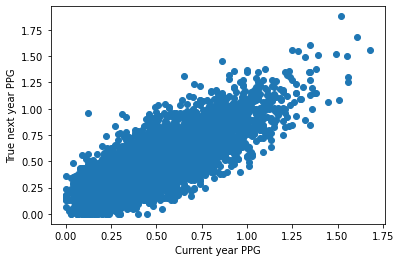

In [7]:
plt.scatter(fitData[5], fitData['Target PPG'])
plt.xlabel("Current year PPG")
plt.ylabel("True next year PPG")
plt.show

In [8]:
# Regression task: Assume players maintain EXACT same production the next year
MSE=np.mean((fitData[5]-fitData['Target PPG'])**2)
print(f'MSE: {MSE}')
print(f'RMSE: {np.sqrt(MSE)}')

MSE: 0.023317440401505834
RMSE: 0.1527004924730298


In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    fitData.drop('Target PPG',axis=1).drop('Target FPPG',axis=1), fitData['Target PPG'], test_size=0.15)

In [10]:
# Linear Regression
lin_reg = LinearRegression()  
lin_reg.fit(X_train, y_train) #training the algorithm
lin_res=lin_reg.predict(X_test)
print(f'MSE: {metrics.mean_squared_error(lin_res,y_test)}')
print(f'RMSE: {np.sqrt(metrics.mean_squared_error(lin_res,y_test))}')

MSE: 0.01752624284356615
RMSE: 0.13238671702087845


We see a small improvement

In [11]:
mlp_reg = MLPRegressor(hidden_layer_sizes=(256,128,64,64,32,16),activation="relu", solver='adam', learning_rate='adaptive' ,random_state=2, max_iter=3000).fit(X_train, y_train)
mlp_res = mlp_reg.predict(X_test)
print(f'MSE: {metrics.mean_squared_error(mlp_res,y_test)}')
print(f'RMSE: {np.sqrt(metrics.mean_squared_error(mlp_res,y_test))}')

MSE: 0.01899371356375739
RMSE: 0.13781768233342698


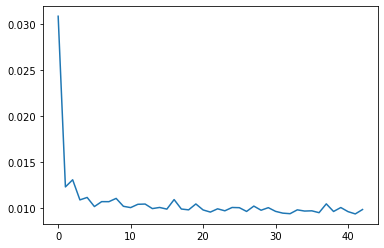

In [12]:
plt.plot(mlp_reg.loss_curve_)

In [13]:
X_train.shape

(5419, 24)

Epoch 1/40
 1/28 [>.............................] - ETA: 4s - loss: 0.1153

2022-01-30 23:53:11.206352: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


28/28 [==============================] - 0s 4ms/step - loss: 0.0359 - val_loss: 0.0239
Epoch 2/40
28/28 [==============================] - 0s 2ms/step - loss: 0.0232 - val_loss: 0.0241
Epoch 3/40
28/28 [==============================] - 0s 2ms/step - loss: 0.0225 - val_loss: 0.0224
Epoch 4/40
28/28 [==============================] - 0s 2ms/step - loss: 0.0225 - val_loss: 0.0199
Epoch 5/40
28/28 [==============================] - 0s 2ms/step - loss: 0.0212 - val_loss: 0.0377
Epoch 6/40
28/28 [==============================] - 0s 2ms/step - loss: 0.0255 - val_loss: 0.0207
Epoch 7/40
28/28 [==============================] - 0s 2ms/step - loss: 0.0210 - val_loss: 0.0194
Epoch 8/40
28/28 [==============================] - 0s 2ms/step - loss: 0.0208 - val_loss: 0.0191
Epoch 9/40
28/28 [==============================] - 0s 2ms/step - loss: 0.0212 - val_loss: 0.0207
Epoch 10/40
28/28 [==============================] - 0s 2ms/step - loss: 0.0207 - val_loss: 0.0182
Epoch 11/40
28/28 [===========

<function matplotlib.pyplot.show(close=None, block=None)>

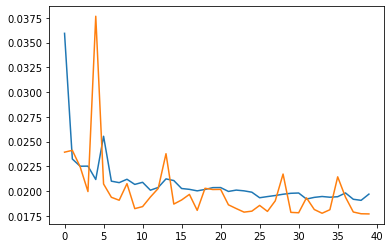

In [14]:
model = Sequential()
model.add(Dense(256, input_dim=24, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='mse', optimizer='adam')
history=model.fit(tf.convert_to_tensor(X_train, np.float64), tf.convert_to_tensor(y_train, np.float64), 
                  epochs=40, batch_size=200,
                  validation_data=(tf.convert_to_tensor(X_test, np.float64), tf.convert_to_tensor(y_test, np.float64)) )
#Plot loss
plt.plot(history.history['loss'] )
plt.plot(history.history['val_loss'] )
plt.show

Let's make predictions for the 2022 season

In [17]:
# Import data for 2022 to test as target
# Target columns are meaningless since we didn't collect 2022 season data.
# One should consult current daily stats to compare
dill_file = open("all_data_min_test", "rb")
all2022 = dill.load(dill_file)
dill_file.close()
all2022.index=range(len(all2022.index))
all2022=all2022.fillna(0)
X2022=all2022.drop('Target FPPG', axis=1).drop('Target PPG', axis=1).drop(0, axis=1)

In [18]:
# Linear model prediction
lin_pred=lin_reg.predict(X2022)
indices=[]
vals=[]
for j in list(np.sort(lin_pred)[-20:]):
    indices.append(np.where(lin_pred==j)[0])
    vals.append(j)
top10=np.unique(np.concatenate(indices))
pair=[]
for i,j in enumerate(top10):
    pair.append((j, vals[i]))
display(pair)
for j in Sort_Tuple(pair):
    ind=j[0]
    print(f'Predicted: (Name:{all2022.loc[ind,0]}, Age:{all2022.loc[ind,3]}, FPPG: {all2022.loc[ind,1]}, PPG: {all2022.loc[ind,5]})')

[(0, 0.8856650530143988),
 (21, 0.8960022318473436),
 (22, 0.897086216563408),
 (107, 0.8992695760325586),
 (108, 0.913560939618248),
 (174, 0.9184576447724843),
 (175, 0.9323438896713747),
 (216, 0.9417056542632936),
 (218, 0.9435967150182204),
 (262, 1.0039212539952809),
 (336, 1.0127949403486365),
 (337, 1.0346844179767445),
 (357, 1.0373623674066321),
 (358, 1.0673861677518763),
 (379, 1.0887632413094288),
 (470, 1.125514160244926),
 (471, 1.1501959185013115),
 (474, 1.2307762934437552),
 (491, 1.2733529181274679),
 (492, 1.4831395707925545)]

Predicted: (Name:Sebastian Aho, Age:23.0, FPPG: 8.967857142857143, PPG: 1.02)
Predicted: (Name:Jonathan Huberdeau, Age:27.0, FPPG: 8.66909090909091, PPG: 1.11)
Predicted: (Name:Aleksander Barkov, Age:25.0, FPPG: 10.828, PPG: 1.16)
Predicted: (Name:Patrick Kane, Age:32.0, FPPG: 9.123214285714285, PPG: 1.18)
Predicted: (Name:Alex DeBrincat, Age:23.0, FPPG: 9.451923076923077, PPG: 1.08)
Predicted: (Name:Sidney Crosby, Age:33.0, FPPG: 9.583636363636364, PPG: 1.13)
Predicted: (Name:Jake Guentzel, Age:26.0, FPPG: 8.623214285714285, PPG: 1.02)
Predicted: (Name:Brad Marchand3, Age:32.0, FPPG: 10.59811320754717, PPG: 1.3)
Predicted: (Name:David Pastrnak, Age:24.0, FPPG: 9.404166666666667, PPG: 1.0)
Predicted: (Name:Artemi Panarin, Age:29.0, FPPG: 10.295238095238094, PPG: 1.38)
Predicted: (Name:Mitch Marner, Age:23.0, FPPG: 10.17090909090909, PPG: 1.22)
Predicted: (Name:Auston Matthews, Age:23.0, FPPG: 12.707692307692307, PPG: 1.27)
Predicted: (Name:Connor McDavid, Age:24.0, FPPG: 14.39285714285

In [19]:
# MLP model prediction
mlp_pred=mlp_reg.predict(X2022)
indices=[]
vals=[]
for j in list(np.sort(mlp_pred)[-20:]):
    indices.append(np.where(mlp_pred==j)[0])
    vals.append(j)
top10=np.unique(np.concatenate(indices))
pair=[]
for i,j in enumerate(top10):
    pair.append((j, vals[i]))
display(pair)
for j in Sort_Tuple(pair):
    ind=j[0]
    print(f'Predicted: (Name:{all2022.loc[ind,0]}, Age:{all2022.loc[ind,3]}, FPPG: {all2022.loc[ind,1]}, PPG: {all2022.loc[ind,5]})')

[(0, 0.8317812572142906),
 (21, 0.8331529953465009),
 (22, 0.8343539986062459),
 (107, 0.83467083706722),
 (108, 0.8384354765469254),
 (175, 0.8514158779490157),
 (216, 0.8760206138806761),
 (218, 0.8891546817263547),
 (262, 0.9030319598906238),
 (336, 0.9117882906845557),
 (337, 0.924448818064425),
 (357, 0.974441580126528),
 (358, 0.9851268193243481),
 (379, 1.0314258073309177),
 (380, 1.1084341202392292),
 (381, 1.110167828464414),
 (470, 1.1409766323454449),
 (471, 1.2001935410721756),
 (474, 1.3408410719869148),
 (491, 1.480327996953568)]

Predicted: (Name:Sebastian Aho, Age:23.0, FPPG: 8.967857142857143, PPG: 1.02)
Predicted: (Name:Jonathan Huberdeau, Age:27.0, FPPG: 8.66909090909091, PPG: 1.11)
Predicted: (Name:Aleksander Barkov, Age:25.0, FPPG: 10.828, PPG: 1.16)
Predicted: (Name:Patrick Kane, Age:32.0, FPPG: 9.123214285714285, PPG: 1.18)
Predicted: (Name:Alex DeBrincat, Age:23.0, FPPG: 9.451923076923077, PPG: 1.08)
Predicted: (Name:Jake Guentzel, Age:26.0, FPPG: 8.623214285714285, PPG: 1.02)
Predicted: (Name:Brad Marchand3, Age:32.0, FPPG: 10.59811320754717, PPG: 1.3)
Predicted: (Name:David Pastrnak, Age:24.0, FPPG: 9.404166666666667, PPG: 1.0)
Predicted: (Name:Artemi Panarin, Age:29.0, FPPG: 10.295238095238094, PPG: 1.38)
Predicted: (Name:Mitch Marner, Age:23.0, FPPG: 10.17090909090909, PPG: 1.22)
Predicted: (Name:Auston Matthews, Age:23.0, FPPG: 12.707692307692307, PPG: 1.27)
Predicted: (Name:Connor McDavid, Age:24.0, FPPG: 14.392857142857142, PPG: 1.88)
Predicted: (Name:Leon Draisaitl, Age:25.0, FPPG: 12.200000000

In [20]:
# keras model prediction
keras_pred=model.predict(tf.convert_to_tensor(X2022, np.float64))
indices=[]
vals=[]
for j in list(np.sort(keras_pred.flatten())[-20:]):
    indices.append(np.where(keras_pred==j)[0])
    vals.append(j)
top10=np.unique(np.concatenate(indices))
pair=[]
for i,j in enumerate(top10):
    pair.append((j, vals[i]))
display(pair)
for j in Sort_Tuple(pair):
    ind=j[0]
    print(f'Predicted: (Name:{all2022.loc[ind,0]}, Age:{all2022.loc[ind,3]}, FPPG: {all2022.loc[ind,1]}, PPG: {all2022.loc[ind,5]})')

[(0, 0.9021257),
 (21, 0.90276873),
 (22, 0.9031971),
 (107, 0.90833604),
 (108, 0.90911996),
 (175, 0.914527),
 (216, 0.92364895),
 (218, 0.9292392),
 (262, 0.96520317),
 (336, 0.970299),
 (337, 0.9727068),
 (357, 0.9760645),
 (358, 0.98298645),
 (379, 0.99252605),
 (380, 0.99483156),
 (381, 0.9954746),
 (470, 0.99580073),
 (471, 0.9978205),
 (474, 0.99878705),
 (491, 0.9996168)]

Predicted: (Name:Sebastian Aho, Age:23.0, FPPG: 8.967857142857143, PPG: 1.02)
Predicted: (Name:Jonathan Huberdeau, Age:27.0, FPPG: 8.66909090909091, PPG: 1.11)
Predicted: (Name:Aleksander Barkov, Age:25.0, FPPG: 10.828, PPG: 1.16)
Predicted: (Name:Patrick Kane, Age:32.0, FPPG: 9.123214285714285, PPG: 1.18)
Predicted: (Name:Alex DeBrincat, Age:23.0, FPPG: 9.451923076923077, PPG: 1.08)
Predicted: (Name:Jake Guentzel, Age:26.0, FPPG: 8.623214285714285, PPG: 1.02)
Predicted: (Name:Brad Marchand3, Age:32.0, FPPG: 10.59811320754717, PPG: 1.3)
Predicted: (Name:David Pastrnak, Age:24.0, FPPG: 9.404166666666667, PPG: 1.0)
Predicted: (Name:Artemi Panarin, Age:29.0, FPPG: 10.295238095238094, PPG: 1.38)
Predicted: (Name:Mitch Marner, Age:23.0, FPPG: 10.17090909090909, PPG: 1.22)
Predicted: (Name:Auston Matthews, Age:23.0, FPPG: 12.707692307692307, PPG: 1.27)
Predicted: (Name:Connor McDavid, Age:24.0, FPPG: 14.392857142857142, PPG: 1.88)
Predicted: (Name:Leon Draisaitl, Age:25.0, FPPG: 12.200000000

# Model Fit -- FPPG

<function matplotlib.pyplot.show(close=None, block=None)>

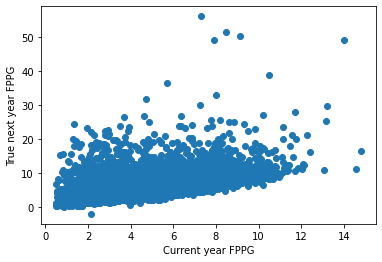

In [21]:
plt.scatter(fitData[1], fitData['Target FPPG'])
plt.xlabel("Current year FPPG")
plt.ylabel("True next year FPPG")
plt.show

Relation appears to be less linear

In [22]:
# Regression task: Assume players maintain EXACT same production the next year. Based on figure above, unlikely to work
MSE=np.mean((fitData[1]-fitData['Target FPPG'])**2)
print(f'MSE: {MSE}')
print(f'RMSE: {np.sqrt(MSE)}')

MSE: 14.184864186673096
RMSE: 3.7662798869272973


In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    fitData.drop('Target PPG',axis=1).drop('Target FPPG',axis=1), fitData['Target FPPG'], test_size=0.15)

In [24]:
# Linear Regression
lin_reg = LinearRegression()  
lin_reg.fit(X_train, y_train) #training the algorithm
lin_res=lin_reg.predict(X_test)
print(f'MSE: {metrics.mean_squared_error(lin_res,y_test)}')
print(f'RMSE: {np.sqrt(metrics.mean_squared_error(lin_res,y_test))}')

MSE: 10.700005464860771
RMSE: 3.2710862820874613


MSE: 10.747163576944464
RMSE: 3.2782866831539406


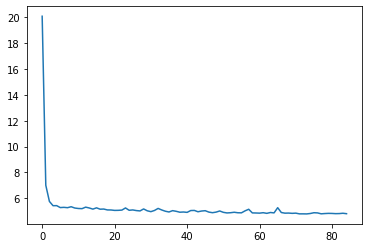

In [25]:
mlp_reg = MLPRegressor(hidden_layer_sizes=(512,256,128,64,64,32,16),activation="relu", solver='adam', learning_rate='adaptive' ,random_state=1, max_iter=3000).fit(X_train, y_train)
mlp_res=mlp_reg.predict(X_test)
print(f'MSE: {metrics.mean_squared_error(mlp_res,y_test)}')
print(f'RMSE: {np.sqrt(metrics.mean_squared_error(mlp_res,y_test))}')
plt.plot(mlp_reg.loss_curve_)

Epoch 1/40
28/28 [==============================] - 0s 3ms/step - loss: 43.8863 - val_loss: 45.0100
Epoch 2/40
28/28 [==============================] - 0s 2ms/step - loss: 43.8230 - val_loss: 45.0100
Epoch 3/40
28/28 [==============================] - 0s 2ms/step - loss: 43.8230 - val_loss: 45.0100
Epoch 4/40
28/28 [==============================] - 0s 2ms/step - loss: 43.8230 - val_loss: 45.0100
Epoch 5/40
28/28 [==============================] - 0s 2ms/step - loss: 43.8230 - val_loss: 45.0100
Epoch 6/40
28/28 [==============================] - 0s 2ms/step - loss: 43.8230 - val_loss: 45.0100
Epoch 7/40
28/28 [==============================] - 0s 2ms/step - loss: 43.8230 - val_loss: 45.0100
Epoch 8/40
28/28 [==============================] - 0s 2ms/step - loss: 43.8230 - val_loss: 45.0100
Epoch 9/40
28/28 [==============================] - 0s 2ms/step - loss: 43.8230 - val_loss: 45.0100
Epoch 10/40
28/28 [==============================] - 0s 2ms/step - loss: 43.8230 - val_loss: 45.0100

<function matplotlib.pyplot.show(close=None, block=None)>

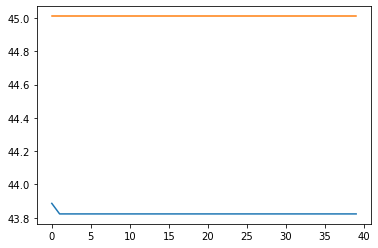

In [27]:
model = Sequential()
model.add(Dense(256, input_dim=24, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='mse', optimizer='adam')
history=model.fit(tf.convert_to_tensor(X_train, np.float64), tf.convert_to_tensor(y_train, np.float64), 
                  epochs=40, batch_size=200,
                  validation_data=(tf.convert_to_tensor(X_test, np.float64), tf.convert_to_tensor(y_test, np.float64)) )
#Plot loss
plt.plot(history.history['loss'] )
plt.plot(history.history['val_loss'] )
plt.show

In [28]:
# Import data for 2022 to test as target
# Target columns are meaningless since we didn't collect 2022 season data.
# One should consult current daily stats to compare
dill_file = open("all_data_min_test", "rb")
all2022 = dill.load(dill_file)
dill_file.close()
all2022.index=range(len(all2022.index))
all2022=all2022.fillna(0)
X2022=all2022.drop('Target FPPG', axis=1).drop('Target PPG', axis=1).drop(0, axis=1)

In [29]:
# Linear model prediction
lin_pred=lin_reg.predict(X2022)
indices=[]
vals=[]
for j in list(np.sort(lin_pred)[-20:]):
    indices.append(np.where(lin_pred==j)[0])
    vals.append(j)
top10=np.unique(np.concatenate(indices))
pair=[]
for i,j in enumerate(top10):
    pair.append((j, vals[i]))
display(pair)
for j in Sort_Tuple(pair):
    ind=j[0]
    print(f'Predicted: (Name:{all2022.loc[ind,0]}, Age:{all2022.loc[ind,3]}, FPPG: {all2022.loc[ind,1]}, PPG: {all2022.loc[ind,5]})')

[(3, 11.251953125),
 (22, 11.38330078125),
 (63, 11.53955078125),
 (107, 11.65234375),
 (174, 11.794921875),
 (198, 11.81298828125),
 (200, 11.8310546875),
 (216, 11.900390625),
 (218, 12.0888671875),
 (262, 12.10205078125),
 (263, 12.361328125),
 (322, 12.3935546875),
 (336, 12.42919921875),
 (337, 12.82373046875),
 (357, 13.13134765625),
 (358, 13.1455078125),
 (381, 13.791015625),
 (470, 14.88037109375),
 (471, 14.97607421875),
 (492, 16.10302734375)]

Predicted: (Name:Dougie Hamilton, Age:27.0, FPPG: 8.909090909090908, PPG: 0.76)
Predicted: (Name:Aleksander Barkov, Age:25.0, FPPG: 10.828, PPG: 1.16)
Predicted: (Name:Roman Josi, Age:30.0, FPPG: 7.58125, PPG: 0.69)
Predicted: (Name:Patrick Kane, Age:32.0, FPPG: 9.123214285714285, PPG: 1.18)
Predicted: (Name:Sidney Crosby, Age:33.0, FPPG: 9.583636363636364, PPG: 1.13)
Predicted: (Name:John Carlson, Age:31.0, FPPG: 7.696153846153846, PPG: 0.85)
Predicted: (Name:Alex Ovechkin, Age:35.0, FPPG: 9.395555555555555, PPG: 0.93)
Predicted: (Name:Brad Marchand3, Age:32.0, FPPG: 10.59811320754717, PPG: 1.3)
Predicted: (Name:David Pastrnak, Age:24.0, FPPG: 9.404166666666667, PPG: 1.0)
Predicted: (Name:Artemi Panarin, Age:29.0, FPPG: 10.295238095238094, PPG: 1.38)
Predicted: (Name:Mika Zibanejad, Age:27.0, FPPG: 8.533928571428572, PPG: 0.89)
Predicted: (Name:Jack Eichel, Age:24.0, FPPG: 6.947619047619048, PPG: 0.86)
Predicted: (Name:Mitch Marner, Age:23.0, FPPG: 10.17090909090909, PPG: 1.22)
Predic

In [30]:
# MLP model prediction
mlp_pred=mlp_reg.predict(X2022)
indices=[]
vals=[]
for j in list(np.sort(mlp_pred)[-20:]):
    indices.append(np.where(mlp_pred==j)[0])
    vals.append(j)
top10=np.unique(np.concatenate(indices))
pair=[]
for i,j in enumerate(top10):
    pair.append((j, vals[i]))
display(pair)
for j in Sort_Tuple(pair):
    ind=j[0]
    print(f'Predicted: (Name:{all2022.loc[ind,0]}, Age:{all2022.loc[ind,3]}, FPPG: {all2022.loc[ind,1]}, PPG: {all2022.loc[ind,5]})')

[(0, 10.921748030427203),
 (3, 10.960843185042167),
 (22, 11.051641735357476),
 (63, 11.214322378525441),
 (107, 11.228572022972628),
 (108, 11.296685262683111),
 (200, 11.350320872304806),
 (216, 11.423123759216555),
 (218, 11.621950663011019),
 (262, 11.932124951959995),
 (263, 12.0199236552308),
 (336, 12.160823830001402),
 (337, 12.928295603737993),
 (357, 14.02834236547893),
 (358, 14.825226480771336),
 (381, 17.528957787998507),
 (470, 19.146638049511672),
 (471, 20.277974801793704),
 (474, 21.978357780105238),
 (492, 27.453032047710966)]

Predicted: (Name:Sebastian Aho, Age:23.0, FPPG: 8.967857142857143, PPG: 1.02)
Predicted: (Name:Dougie Hamilton, Age:27.0, FPPG: 8.909090909090908, PPG: 0.76)
Predicted: (Name:Aleksander Barkov, Age:25.0, FPPG: 10.828, PPG: 1.16)
Predicted: (Name:Roman Josi, Age:30.0, FPPG: 7.58125, PPG: 0.69)
Predicted: (Name:Patrick Kane, Age:32.0, FPPG: 9.123214285714285, PPG: 1.18)
Predicted: (Name:Alex DeBrincat, Age:23.0, FPPG: 9.451923076923077, PPG: 1.08)
Predicted: (Name:Alex Ovechkin, Age:35.0, FPPG: 9.395555555555555, PPG: 0.93)
Predicted: (Name:Brad Marchand3, Age:32.0, FPPG: 10.59811320754717, PPG: 1.3)
Predicted: (Name:David Pastrnak, Age:24.0, FPPG: 9.404166666666667, PPG: 1.0)
Predicted: (Name:Artemi Panarin, Age:29.0, FPPG: 10.295238095238094, PPG: 1.38)
Predicted: (Name:Mika Zibanejad, Age:27.0, FPPG: 8.533928571428572, PPG: 0.89)
Predicted: (Name:Mitch Marner, Age:23.0, FPPG: 10.17090909090909, PPG: 1.22)
Predicted: (Name:Auston Matthews, Age:23.0, FPPG: 12.707692307692307, PPG: 1.27)